# Idea

Statistical arbitrage through pairs trading with cointegrated pairs:
  - Time horizon of data: 4h, 8h, 12h, 24h, 48h
  - Method of identification of cointegrated pairs
      - Fixed set of cointegrated pairs calculated from a training period
      - Dynamically determined cointegrated pairs calculated each period or every several periods
  - Method of hedge-ratio calculation:
      - Pairs with a fixed hedge ratio calculated from a training period
      - Pairs with a dynamic hedge ratio calculated from a look-back period
  - Significance level for being considered cointegrated:
      - 0.10
      - 0.05
      - 0.02
  - Entry and exit levels
  - Lookback window length to calculate z-score (presumably shorter than window to calculate dynamic hedge ratio)


Separate idea:
  - Use price for cointegration or use returns for cointegration
  
  
Also consider baskets instead.

# Methodology

To be filled in: detail the steps, including data acquisition, cointegration testing, and the backtesting process.

# Results

To be filled in: summarize the key performance metrics you calculated.

# Future Work

To be filled in: mention potential improvements, such as adding more pairs, optimizing entry/exit rules, or incorporating more advanced statistical models like the Kalman filter.

Relevant sources:
  - https://medium.com/@trading.dude/unlocking-the-hidden-potential-using-statistical-arbitrage-as-an-indicator-in-python-a8595392def4
  - https://github.com/nirajdsouza/statistical-arbitage-strategy

# Imports

In [130]:
# import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from binance.client import Client as bnb_client
from datetime import datetime
from statsmodels.tsa.stattools import coint

from ipynb.fs.full.utility_functions import (
    get_train_test_data,
    get_alpha_beta_to_asset,
    get_gross_returns_and_net_returns,
    get_rank_demeaned_normalized_signal,
    get_strategy_stats,
)

# Get Historical Data For Cryptocurrencies

In [2]:
# The universe is based on this snapshot from December 20, 2020: https://coinmarketcap.com/historical/20201220/

univ = [
    "BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT", "DOTUSDT", "MATICUSDT", "LTCUSDT", "BCHUSDT",
    "LINKUSDT", "XLMUSDT", "USDCUSDT", "EOSUSDT", "TRXUSDT", "XTZUSDT", "FILUSDT", "NEOUSDT", "DAIUSDT",
    "DASHUSDT", "VETUSDT", "ATOMUSDT", "AAVEUSDT", "UNIUSDT", "GRTUSDT", "THETAUSDT", "IOTAUSDT", "BUSDUSDT",
    "ZECUSDT", "YFIUSDT", "ETCUSDT", "WAVESUSDT", "COMPUSDT", "SNXUSDT", "DOGEUSDT", "MKRUSDT", "ZILUSDT",
    "SUSHIUSDT", "KSMUSDT", "OMGUSDT", "ONTUSDT", "ALGOUSDT", "EGLDUSDT", "BATUSDT", "DGBUSDT", "ZRXUSDT",
    "TUSDUSDT", "QTUMUSDT", "ICXUSDT", "AVAXUSDT", "RENUSDT", "HBARUSDT", "NEARUSDT", "LRCUSDT", "CELOUSDT",
    "KNCUSDT", "LSKUSDT", "OCEANUSDT", "QNTUSDT", "USTUSDT", "BANDUSDT", "MANAUSDT", "ENJUSDT", "ANTUSDT",
    "BNTUSDT", "ZENUSDT", "NMRUSDT", "RVNUSDT", "IOSTUSDT", "OXTUSDT", "CRVUSDT", "MATICUSDT", "HNTUSDT",
    "BALUSDT", "CHZUSDT"
]

should_download_stock_data = False

In [3]:
client = bnb_client(tld='US')

def get_binance_px(symbol, freq, start_ts = '2020-12-20'):
    data = client.get_historical_klines(symbol, freq, start_ts)
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume',
               'num_trades', 'taker_base_volume', 'taker_quote_volume', 'ignore']
    data = pd.DataFrame(data, columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 


if should_download_stock_data:
    freq = '4h'
    px = {}
    for x in univ:
        print(f"Downloading data for symbol {x}")
        data = get_binance_px(x, freq)
        px[x] = data.set_index('open_time')['close']

    px = pd.DataFrame(px).astype(float)
    px.to_csv('./class_project_input_prices.csv')
else:
    px = pd.read_csv('./class_project_input_prices.csv')
    date_format = "%Y-%m-%d %H:%M:%S"
    px['open_time'] = px['open_time'].apply(lambda t:  datetime.strptime(t, date_format))
    px.set_index('open_time', inplace=True)

# Data up to 2025-08-31 08:00:00
px_popular = px[["BTCUSDT", "ETHUSDT", "LTCUSDT", "XRPUSDT", "ADAUSDT"]]

In [4]:
t = datetime(2024, 1, 1, 0, 0)

popular_train_px, popular_test_px = get_train_test_data(px_popular, t)

# Identifying cointegrated pairs

In [5]:
def find_cointegrated_pairs(data, significance_level=0.05):
    """
    Finds cointegrated pairs using the Engle-Granger two-step method.
    Returns a list of cointegrated pairs with their p-value.
    """
    n = data.shape[1]
    keys = data.columns
    pvalue_matrix = pd.DataFrame(np.ones((n, n)), index=keys, columns=keys)
    pairs = []

    for i in range(n):
        for j in range(i + 1, n):
            series1 = data[keys[i]]
            series2 = data[keys[j]]
            
            joint_non_na_series1 = series1.loc[series1.notna() & series2.notna()]
            joint_non_na_series2 = series2.loc[series1.notna() & series2.notna()]
            
            if len(joint_non_na_series1) == 0 or len(joint_non_na_series2) == 0:
                pvalue_matrix.loc[keys[i], keys[j]] = 1.0
                continue

            # Perform the cointegration test
            score, pvalue, _ = coint(joint_non_na_series1, joint_non_na_series2)
            pvalue_matrix.loc[keys[i], keys[j]] = pvalue

            if pvalue < significance_level:
                pairs.append((keys[i], keys[j], pvalue))
    return pvalue_matrix, pairs

In [ ]:
# Find the cointegrated pairs
pvalue_matrix, cointegrated_pairs = find_cointegrated_pairs(popular_train_px)

Cointegration Test P-value Matrix:


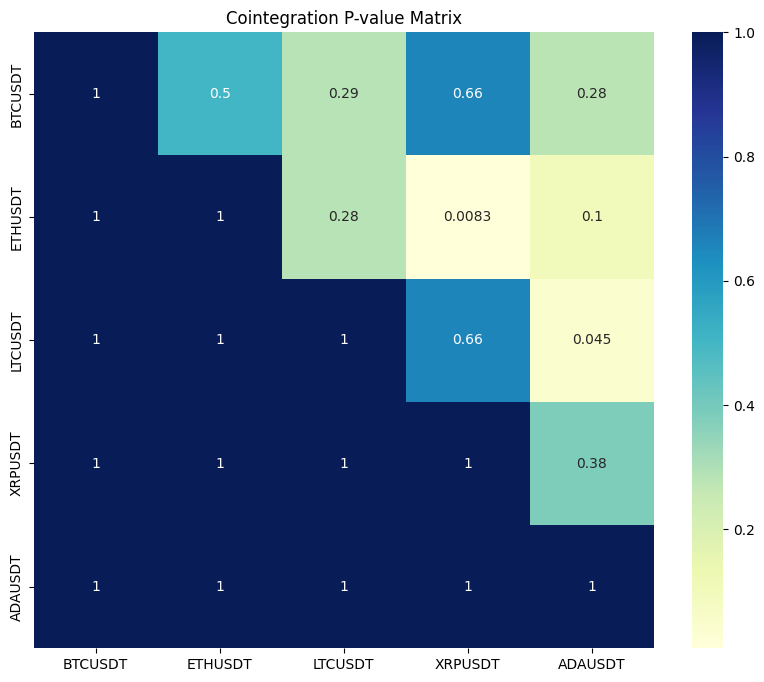


Found Cointegrated Pairs:
Pair: ETHUSDT and XRPUSDT, P-value: 0.0083
Pair: LTCUSDT and ADAUSDT, P-value: 0.0454


In [7]:
print("Cointegration Test P-value Matrix:")
plt.figure(figsize=(10, 8))
sns.heatmap(pvalue_matrix, xticklabels=pvalue_matrix.columns, yticklabels=pvalue_matrix.columns, cmap='YlGnBu', annot=True)
plt.title('Cointegration P-value Matrix')
plt.show()

print("\nFound Cointegrated Pairs:")
for pair in cointegrated_pairs:
    print(f"Pair: {pair[0]} and {pair[1]}, P-value: {pair[2]:.4f}")

# Implementation

In [106]:
# px is expected to have data for every 4 hours
def get_horizon_to_px(px_df):
    start_time = px_df.index[0]
    end_time = px_df.index[-1]
    return {
        4: px_df,
        8: px_df[px_df.index.hour % 8 == 0],
        12: px_df[px_df.index.hour % 12 == 0],
        24: px_df[px_df.index.hour == 0],
        48: px_df[px_df.index.hour == 0].loc[pd.date_range(start=start_time, end=end_time, freq='2D')],
    }


def get_cointegrated_pairs_with_window(
    training_px,
    num_look_back_periods,
    num_periods_between_recalculation,
    significance_level
):
    time_to_cointegrated_pairs = dict()
    df_index = training_px.index
    for index in range(0, len(training_px), num_periods_between_recalculation):
        look_back_index = max(0, index - num_look_back_periods)
        if look_back_index == 0:
            continue
        input_px = training_px.iloc[look_back_index:index]
        
        time_to_cointegrated_pairs[df_index[index]] = find_cointegrated_pairs(input_px, significance_level)[1]
    return time_to_cointegrated_pairs


# forward fill the indices from time_series_index with the values in time_map based on
# the most recent key from time_map.
def fill_time_map(time_map, time_series_index):
    sorted_keys = sorted(list(time_map.keys()))
    all_times_to_coint_pairs = dict()

    sorted_keys_index = None

    for index in range(len(time_series_index)):
        current_time = time_series_index[index]

        if sorted_keys_index is None and current_time >= sorted_keys[0]:
            sorted_keys_index = 0
        while sorted_keys_index is not None and ((sorted_keys_index + 1) < len(sorted_keys)) and current_time >= sorted_keys[sorted_keys_index + 1]:
            sorted_keys_index += 1

        if sorted_keys_index is not None:
            all_times_to_coint_pairs[current_time] = time_map[sorted_keys[sorted_keys_index]]
        else:
            all_times_to_coint_pairs[current_time] = []
    
    return all_times_to_coint_pairs


def calculate_alpha_beta_at_index(px_df, index, num_look_back_periods, dependent_coin, independent_coin):
    start_index = max(0, index - num_look_back_periods)
    dependent_data = px_df[dependent_coin].iloc[start_index:index]
    independent_data = px_df[independent_coin].iloc[start_index:index]
    
    alpha, beta = get_alpha_beta_to_asset(dependent_data, independent_data)
    return alpha, beta


def get_times_to_cointegrated_pairs_to_hedges(
    horizon_px_df,
    all_times_to_cointegrated_pairs,
    num_look_back_periods,
    num_periods_between_recalculation,
    significance_level):
    
    times_to_cointegrated_pairs_to_hedges = dict()
    horizon_px_df_index = horizon_px_df.index
    for index in range(0, len(horizon_px_df), num_periods_between_recalculation):
        current_time = horizon_px_df_index[index]
        times_to_cointegrated_pairs_to_hedges[current_time] = dict()
        
        for independent_coin, dependent_coin, _ in all_times_to_cointegrated_pairs[current_time]:
            times_to_cointegrated_pairs_to_hedges[current_time][
                (independent_coin, dependent_coin)] = calculate_alpha_beta_at_index(
                    horizon_px_df, index, num_look_back_periods, dependent_coin, independent_coin)
    
    return times_to_cointegrated_pairs_to_hedges


def get_raw_signal(all_times_to_coint_pairs, px_df):
    signal_map = dict()

    for index, value in all_times_to_coint_pairs.items():
        signal_row = pd.Series(0.0, index = px_df.columns)

        for (independent_coin, dependent_coin), (alpha, beta) in value.items():
            dependent_coin_estimate = px_df.loc[index, independent_coin] * beta + alpha

            if px_df.loc[index, dependent_coin] >= dependent_coin_estimate:
                # dependent_coin is overvalued relative to independent_coin; short one share of it
                # independent_coin is undervalued relative to dependent_coin; long beta shares of it

                signal_row[independent_coin] += beta
                signal_row[dependent_coin] -= 1.0
            else:
                # dependent_coin is undervalued relative to independent_coin; long one share of it
                # independent_coin is overvalues relative to dependent_coin; short one share of it

                signal_row[independent_coin] -= beta
                signal_row[dependent_coin] += 1.0

        signal_map[index] = signal_row

    return pd.DataFrame(signal_map).T


def get_returns_from_dynamic_cointegration(time_horizon_hours, horizon_px_df):
    
    time_to_cointegrated_pairs = get_cointegrated_pairs_with_window(
        horizon_px_df,
        num_look_back_periods = 6 * 7 * 8,
        num_periods_between_recalculation = 6 * 7 * 4,
        significance_level = 0.05)
    
    all_times_to_cointegrated_pairs = fill_time_map(
        time_to_cointegrated_pairs, horizon_px_df.index)
    
    time_to_cointegrated_pairs_to_hedges = get_times_to_cointegrated_pairs_to_hedges(
        horizon_px_df,
        all_times_to_cointegrated_pairs,
        num_look_back_periods = 6 * 7 * 8,
        num_periods_between_recalculation = 6 * 7 * 4,
        significance_level = 0.05)
    
    all_times_to_cointegrated_pairs_to_hedges = fill_time_map(
        time_to_cointegrated_pairs_to_hedges, horizon_px_df.index)
    
    raw_signal = get_raw_signal(all_times_to_cointegrated_pairs_to_hedges, horizon_px_df)
    transformed_signal = get_rank_demeaned_normalized_signal(raw_signal)
    return get_gross_returns_and_net_returns(transformed_signal, horizon_px_df)


# original_px_df should have data for every 4 hours
def get_all_gross_returns_and_net_returns(original_px_df):
    # return map from variations to pair of dataframes of gross returns and net returns
    variation_to_returns = dict()
    
    horizon_to_px = get_horizon_to_px(original_px_df)
    for time_horizon_hours in (4, 8, 12, 24, 48):
        gross_returns, net_returns = get_returns_from_dynamic_cointegration(
            time_horizon_hours, horizon_to_px[time_horizon_hours]
        )
    
        variation_to_returns[time_horizon_hours] = net_returns

    return variation_to_returns

In [ ]:
x = get_returns_from_dynamic_cointegration(4, popular_train_px)

In [89]:
gross_returns, net_returns = get_gross_returns_and_net_returns(x, popular_train_px)

In [110]:
full_train_px, full_test_px = get_train_test_data(px, t)

In [ ]:
gross_returns, net_returns = get_returns_from_dynamic_cointegration(4, full_train_px)

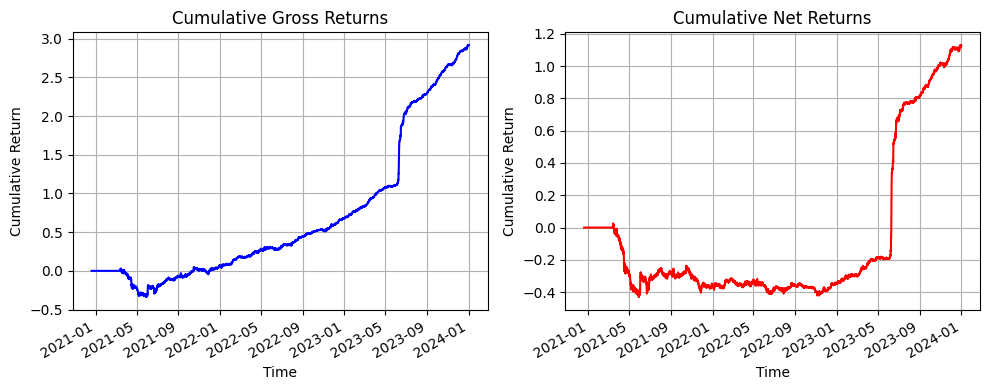

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns.cumsum().plot(ax=axes[0], title='Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns.cumsum().plot(ax=axes[1], title='Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
gross_returns_8h, net_returns_8h = get_returns_from_dynamic_cointegration(
    8, get_horizon_to_px(full_train_px)[8])

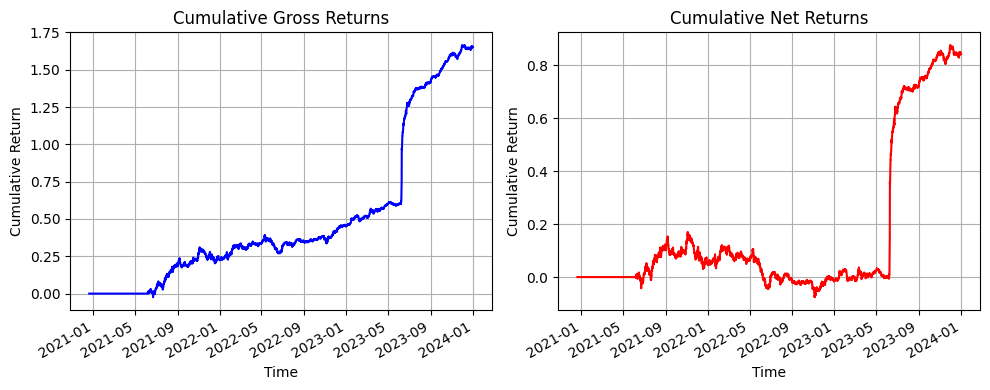

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns_8h.cumsum().plot(ax=axes[0], title='Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns_8h.cumsum().plot(ax=axes[1], title='Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

In [124]:
gross_returns_12h, net_returns_12h = get_returns_from_dynamic_cointegration(
    12, get_horizon_to_px(full_train_px)[12])

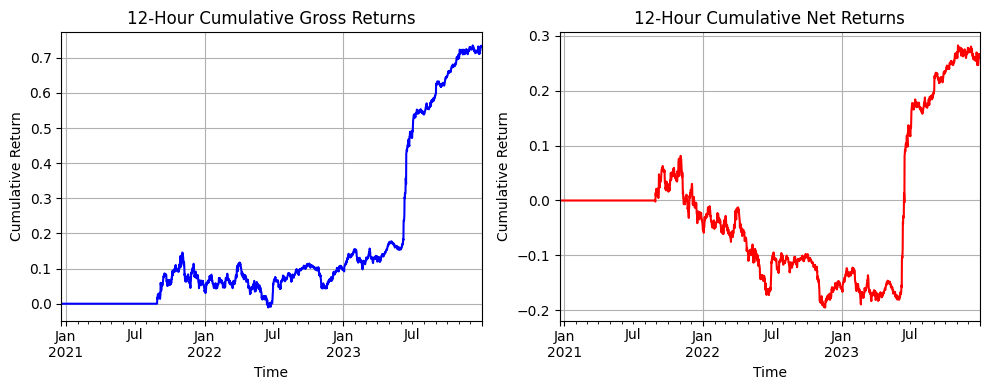

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns_12h.cumsum().plot(ax=axes[0], title='12-Hour Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns_12h.cumsum().plot(ax=axes[1], title='12-Hour Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

In [127]:
gross_returns_24h, net_returns_24h = get_returns_from_dynamic_cointegration(
    24, get_horizon_to_px(full_train_px)[24])

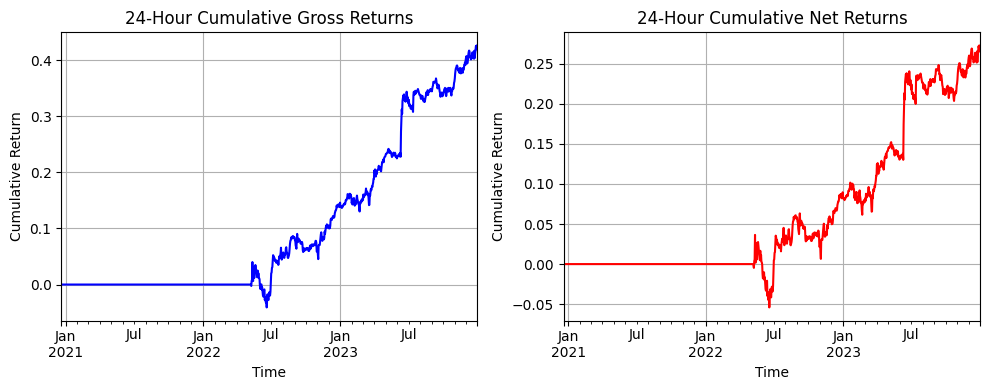

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns_24h.cumsum().plot(ax=axes[0], title='24-Hour Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns_24h.cumsum().plot(ax=axes[1], title='24-Hour Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

In [129]:
results_map = {
    "gross returns, 4h": gross_returns,
    "net returns, 4h": net_returns,
    "gross returns, 8h": gross_returns_8h,
    "net returns, 8h": net_returns_8h,
    "gross returns, 12h": gross_returns_12h,
    "net returns, 12h": net_returns_12h,
    "gross returns, 24h": gross_returns_24h,
    "net returns, 24h": net_returns_24h,
}

should_write_map = False

if should_write_map:
    pd.DataFrame(results_map).to_csv('./cointegration_results.csv', index=True)

In [136]:
pd.Series(get_strategy_stats(net_returns, 4, get_horizon_to_px(full_train_px)[4])).to_frame()

,0
avg returns,0.372004
decorrelated avg returns,0.374898
volatility,0.219592
sharpe ratio,1.694071
decorrelated sharpe ratio,1.707486
max drawdown,-17.930030
max drawdown duration,816.166667
alpha_BTC,0.000171
beta_BTC,-0.006838


- Time horizon of data: 4h, 8h, 12h, 24h, 48h
- Method of identification of cointegrated pairs
    - Fixed set of cointegrated pairs calculated from a training period
    - Dynamically determined cointegrated pairs calculated each period or every several periods
- Method of hedge-ratio calculation:
    - Pairs with a fixed hedge ratio calculated from a training period
    - Pairs with a dynamic hedge ratio calculated from a look-back period
- Significance level for being considered cointegrated:
    - 0.10
    - 0.05
    - 0.02
- Entry and exit levels
- Lookback window length to calculate z-score (presumably shorter than window to calculate dynamic hedge ratio)

Separate idea:
- Use price for cointegration or use returns for cointegration

In [ ]:
train_px_4h = get_horizon_to_px(popular_train_px)[4]

time_to_cointegrated_pairs = get_cointegrated_pairs_with_window(
    train_px_4h,
    num_look_back_periods = 6 * 7 * 8, # 8 weeks
    num_periods_between_recalculation = 6 * 7 * 2, # 2 weeks
    significance_level = 0.05)

time_to_cointegrated_pairs

In [ ]:
def get_updated_cointegration_index(
        cointegration_index,
        cointegration_recalculation_times,
        index,
        train_px_index_list
    ):
    if (cointegration_index is None and \
        train_px_index_list[index] >= cointegration_recalculation_times[0]):
        cointegration_index = 0
    elif cointegration_index is not None:
        while ((cointegration_index + 1) < len(cointegration_recalculation_times)) and \
            (train_px_index_list[index] >= cointegration_recalculation_times[cointegration_index + 1]):
            cointegration_index += 1
    
    return cointegration_index


def construct_signal(signal, cointegrated_pairs):
    pass


time_to_signal = dict()

cointegration_recalculation_times = sorted(list(time_to_cointegrated_pairs.keys()))
cointegration_index = None

train_px_index_list = train_px_4h.index
for index in range(len(train_px_4h)):
    cointegration_index = get_updated_cointegration_index(
        cointegration_index,
        cointegration_recalculation_times,
        index,
        train_px_index_list
    )
    
    if cointegration_index is None:
        time_to_signal[train_px_index_list[index]] = pd.Series(np.nan, index=train_px_4h.columns)
        continue
    
    _, cointegrated_pairs = time_to_cointegrated_pairs[cointegration_recalculation_times[cointegration_index]]
    
    signal = pd.Series(0.0, index = train_px_4h.columns)
    
    time_to_signal[train_px_index_list[index]] = construct_signal(signal, cointegrated_pairs)

In [9]:


# def get_gross_and_net_returns_for_all_dynamic_cointegration_combinations(px):
#     horizon_to_px = get_horizon_to_px(px, datetime(2020, 12, 20), datetime(2023, 12, 31))
    
#     for num_hours in (4, 8, 12, 24, 48):
#         train_px_horizon = horizon_to_px[num_hours]
    
#         significance_level = 0.05
#         num_periods_between_recalculation = 24 / num_hours * 30
#         num_look_back_periods = 2 * num_periods_between_recalculation
        
#         time_to_cointegrated_pairs = get_cointegrated_pairs_with_window(
#             train_px_horizon, num_look_back_periods, num_periods_between_recalculation, significance_level)
        
        

    
# def get_gross_and_net_returns_for_fixed_cointegration_combinations(px):
#     pass

In [ ]:
horizon_to_px = get_horizon_to_px(popular_train_px, datetime(2020, 12, 20), datetime(2023, 12, 31))

num_hours = 4

# for num_hours in (4, 8, 12, 24, 48):
#     train_px_horizon = horizon_to_px[num_hours]

#     significance_level = 0.05
#     num_periods_between_recalculation = 24 / num_hours * 30
#     num_look_back_periods = 2 * num_periods_between_recalculation

#     time_to_cointegrated_pairs = get_cointegrated_pairs_with_window(
#         train_px_horizon, num_look_back_periods, num_periods_between_recalculation, significance_level)

train_px_horizon = horizon_to_px[num_hours]

significance_level = 0.05
num_periods_between_recalculation = int(24 / num_hours * 30)
num_look_back_periods = 2 * num_periods_between_recalculation

time_to_cointegrated_pairs = get_cointegrated_pairs_with_window(
    train_px_horizon, num_look_back_periods, num_periods_between_recalculation, significance_level)

In [24]:
cointegration_identification_times = sorted(list(time_to_cointegrated_pairs.keys()))
cointegration_index = None
signal_map = dict()
date_index_arr = train_px_horizon.index


def get_updated_cointegration_index(cointegration_idx, time_idx, coint_id_times):
    if cointegration_idx is None:
        

for index in range(len(train_px_horizon)):
    time_index = date_index_arr[index]
    cointegration_index = get_updated_cointegration_index(cointegration_index, time_index, cointegration_identification_times)
    signal_map[time_index] = get_signal_at_index(index, time_index, train_px_horizon, cointegrated_pairs, hedge_map)

[Timestamp('2021-03-20 00:00:00'),
 Timestamp('2021-04-19 00:00:00'),
 Timestamp('2021-05-19 00:00:00'),
 Timestamp('2021-06-18 00:00:00'),
 Timestamp('2021-07-18 04:00:00'),
 Timestamp('2021-08-17 04:00:00'),
 Timestamp('2021-09-16 04:00:00'),
 Timestamp('2021-10-16 04:00:00'),
 Timestamp('2021-11-15 04:00:00'),
 Timestamp('2021-12-15 04:00:00'),
 Timestamp('2022-01-14 04:00:00'),
 Timestamp('2022-02-13 04:00:00'),
 Timestamp('2022-03-15 04:00:00'),
 Timestamp('2022-04-14 04:00:00'),
 Timestamp('2022-05-14 04:00:00'),
 Timestamp('2022-06-13 04:00:00'),
 Timestamp('2022-07-13 04:00:00'),
 Timestamp('2022-08-12 04:00:00'),
 Timestamp('2022-09-11 04:00:00'),
 Timestamp('2022-10-11 04:00:00'),
 Timestamp('2022-11-10 04:00:00'),
 Timestamp('2022-12-10 04:00:00'),
 Timestamp('2023-01-09 04:00:00'),
 Timestamp('2023-02-08 08:00:00'),
 Timestamp('2023-03-10 08:00:00'),
 Timestamp('2023-04-09 08:00:00'),
 Timestamp('2023-05-09 08:00:00'),
 Timestamp('2023-06-08 08:00:00'),
 Timestamp('2023-07-

# Backtesting the strategy for one pair


Backtesting the strategy for the pair: LTCUSDT and ADAUSDT
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_1125/3785399861.py:53: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  backtest_df['signal'] = backtest_df['signal'].replace(to_replace=0, method='ffill')


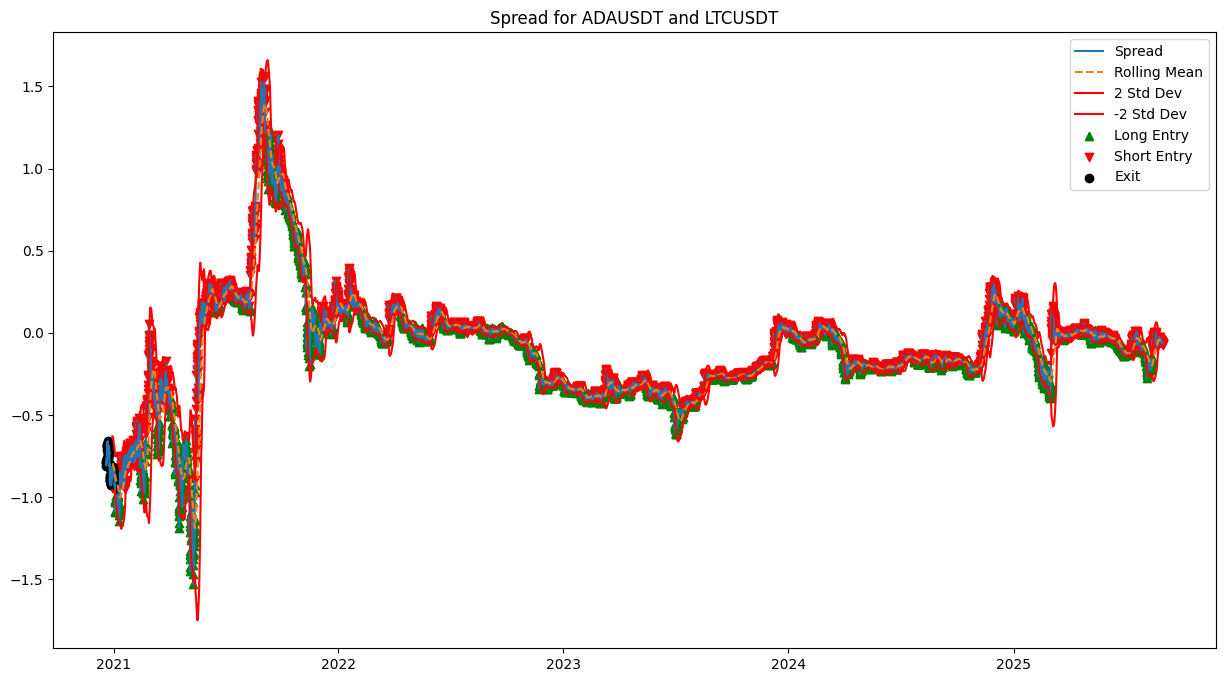

In [52]:
import statsmodels.api as sm

# --- Select a cointegrated pair for backtesting (e.g., BTC and ETH) ---
asset_x = 'LTCUSDT'
asset_y = 'ADAUSDT'

# Check if the selected pair is actually cointegrated
if (asset_x, asset_y, pvalue_matrix.loc[asset_x, asset_y]) in cointegrated_pairs or \
   (asset_y, asset_x, pvalue_matrix.loc[asset_y, asset_x]) in cointegrated_pairs:
    print(f"\nBacktesting the strategy for the pair: {asset_x} and {asset_y}")
else:
    print(f"\nWarning: The pair {asset_x} and {asset_y} is not found to be cointegrated at the 5% significance level.")
    print("Please choose a valid cointegrated pair from the previous step.")

# --- Calculate the hedge ratio and spread ---
# Perform a linear regression to find the hedge ratio
model = sm.OLS(px_popular[asset_y], sm.add_constant(px_popular[asset_x])).fit()
hedge_ratio = model.params[asset_x]
spread = px_popular[asset_y] - hedge_ratio * px_popular[asset_x]

# --- Backtesting logic ---
# Define trading parameters
window = 60 # Lookback window for mean and std dev
num_std_dev_entry = 2 # Number of standard deviations for entry
num_std_dev_exit = 0.5 # Number of standard deviations for exit

# Calculate rolling mean and standard deviation of the spread
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()

# Calculate Bollinger Bands
upper_band = rolling_mean + num_std_dev_entry * rolling_std
lower_band = rolling_mean - num_std_dev_entry * rolling_std

# Create DataFrame for backtest
backtest_df = pd.DataFrame(index=spread.index)
backtest_df['spread'] = spread
backtest_df['rolling_mean'] = rolling_mean
backtest_df['rolling_std'] = rolling_std
backtest_df['upper_band'] = upper_band
backtest_df['lower_band'] = lower_band

# --- Generate trading signals ---
# Signal: 1 for long spread, -1 for short spread, 0 for no position
backtest_df['signal'] = 0.0
backtest_df.loc[backtest_df['spread'] > backtest_df['upper_band'], 'signal'] = -1.0
backtest_df.loc[backtest_df['spread'] < backtest_df['lower_band'], 'signal'] = 1.0

# Exit signal: close position when spread reverts to near the mean
backtest_df.loc[abs(backtest_df['spread']) < num_std_dev_exit * backtest_df['rolling_std'], 'signal'] = 0.0

# Forward-fill signals to hold positions
backtest_df['signal'] = backtest_df['signal'].replace(to_replace=0, method='ffill')

# --- Plot the spread and trading signals ---
plt.figure(figsize=(15, 8))
plt.plot(backtest_df.index, backtest_df['spread'], label='Spread')
plt.plot(backtest_df.index, backtest_df['rolling_mean'], label='Rolling Mean', linestyle='--')
plt.plot(backtest_df.index, backtest_df['upper_band'], label=f'{num_std_dev_entry} Std Dev', color='red')
plt.plot(backtest_df.index, backtest_df['lower_band'], label=f'-{num_std_dev_entry} Std Dev', color='red')
plt.title(f'Spread for {asset_y} and {asset_x}')

# Highlight entry and exit points
long_entries = backtest_df[backtest_df['signal'] == 1].index
short_entries = backtest_df[backtest_df['signal'] == -1].index
exits = backtest_df[backtest_df['signal'] == 0].index

plt.scatter(long_entries, backtest_df.loc[long_entries, 'spread'], marker='^', color='green', label='Long Entry')
plt.scatter(short_entries, backtest_df.loc[short_entries, 'spread'], marker='v', color='red', label='Short Entry')
plt.scatter(exits, backtest_df.loc[exits, 'spread'], marker='o', color='black', label='Exit')

plt.legend()
plt.show()

In [58]:
backtest_df.iloc[110:140]

,spread,rolling_mean,rolling_std,upper_band,lower_band,signal
open_time,,,,,,
2021-01-07 08:00:00,-1.033145,-0.923336,0.088658,-0.746020,-1.100652,1.0
2021-01-07 12:00:00,-1.051067,-0.926090,0.090029,-0.746033,-1.106148,1.0
2021-01-07 16:00:00,-1.069100,-0.929113,0.091748,-0.745618,-1.112608,1.0
2021-01-07 20:00:00,-1.059315,-0.932316,0.092895,-0.746527,-1.118105,1.0
2021-01-08 00:00:00,-0.987506,-0.934923,0.092198,-0.750528,-1.119318,1.0
2021-01-08 04:00:00,-0.998661,-0.937630,0.091634,-0.754362,-1.120898,1.0
2021-01-08 08:00:00,-1.070955,-0.941367,0.092433,-0.756500,-1.126233,1.0
2021-01-08 12:00:00,-1.088167,-0.945904,0.092852,-0.760199,-1.131609,1.0
2021-01-08 16:00:00,-1.071169,-0.950000,0.092868,-0.764264,-1.135735,1.0


# Performance evaluation

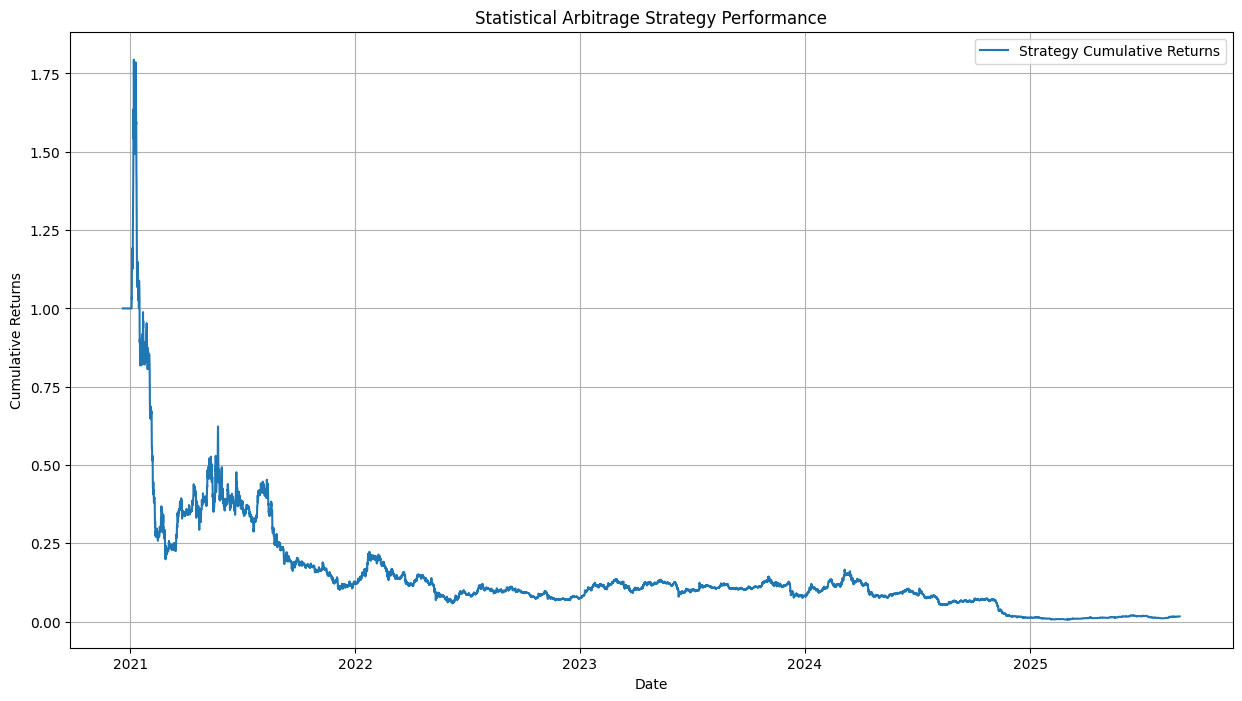


Strategy Performance Metrics:
Total Cumulative Return: -98.33%
Annualized Return: -0.06
Annualized Volatility: 0.40
Sharpe Ratio: -0.15


In [51]:
# --- Calculate daily returns of the assets ---
returns_x = px_popular[asset_x].pct_change()
returns_y = px_popular[asset_y].pct_change()

# --- Calculate strategy returns ---
# When 'signal' is 1 (long spread): long Y, short X
# When 'signal' is -1 (short spread): short Y, long X
strategy_returns = backtest_df['signal'].shift(1) * (returns_y - hedge_ratio * returns_x)

# --- Calculate cumulative returns ---
strategy_returns.dropna(inplace=True)
cumulative_returns = (1 + strategy_returns).cumprod()

# --- Plot cumulative returns ---
plt.figure(figsize=(15, 8))
plt.plot(cumulative_returns, label='Strategy Cumulative Returns')
plt.title('Statistical Arbitrage Strategy Performance')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

# --- Calculate performance metrics ---
total_return = (cumulative_returns.iloc[-1] - 1) * 100
annualized_return = (1 + strategy_returns.mean())**365 - 1
annualized_volatility = strategy_returns.std() * np.sqrt(365)
sharpe_ratio = annualized_return / annualized_volatility

print("\nStrategy Performance Metrics:")
print(f"Total Cumulative Return: {total_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}")
print(f"Annualized Volatility: {annualized_volatility:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")